In [1]:
#usefull packages
import numpy as np
import pandas as pd
import random as rd
import copy
import time
import matplotlib.pyplot as plt

#pycuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Projet Element Logiciel Pour le Traitement de Donnees Massives

## Autour de l'article, présentation du projet

<p style="text-align:justify">
L'idée du projet est de paralléliser l'algorithme word2vec. On s'appuie pour cela sur l'article de Ji, Shihao, et al. <i>. Parallelizing word2vec in shared and distributed memory</i> (https://arxiv.org/pdf/1604.04661.pdf). Nous avons utilisé <i> pycuda </i> pour effectuer la programmation GPU. Dans ce notebook on utilise donc le langage Python comme langage d'environnement : on s'en sert principalement pour préparer les données, présenter les résultats et exécuter les fonctions à paralléliser. L'algorithme d'entraînement du réseau de neurones word2vec est en revanche codé en C.
</p>

<p style="text-align:justify">
L'algorithme word2vec permet de représenter les mots d'un texte dans un espace de petite dimension (typiquement $\mathbb{R}^d$ avec d de l'ordre de 10). Il permet donc de passer d'une représentation des données sous forme one-hot (où la taille de l'espace des données est égale à la taille du vocabulaire du corpus de texte étudié) à une représentaion dans $\mathbb{R}^d$. L'idée est que, des mots proches sémantiquement (on les suppose proches si ils sont proches dans le texte) doivent être proches dans l'espace de projection $\mathbb{R}^d$(au sens euclidien cette fois).
</p>

<p style="text-align:justify">
L'architecture de word2vec est un réseau de neurones à une couche cachée. Si l'on souhaite que notre espace de projection (celui dans lequel on souhaite représenter les mots) soit $\mathbb{R}^d$, on choisira d neurones dans la couche cachée. Les couches d'entrée et de sortie sont de taille $V$ où $V$ est la taille du vocabulaire du corpus de texte étudié. Pour construire notre matrice de projection dans $\mathbb{R}^d$, on entraîne ce réseau de neurones via une tâche de prédiction annexe. Pour un mot en entrée, le réseau doit prédire le où les mots les plus proches sémantiquement. La matrice des poids de passage de la couche d'input à la couche cachée sera alors notre matrice de projection. On construit donc un ensemble d'entraînement $(X,Y)$ où on fixe la taille N du contexte utilisé et les couples $(X_i,Y_i)$ sont determinés de la manière suivante : pour un mot $X_i$ du texte et pour les mots $Y_{i,1}, Y_{i,2},...,Y_{i,N}$ qui sont autour du mot $X_i$ dans le texte, les couples $(X_i,Y_{i,1})$,...$(X_i,Y_{i,N})$ forment la base d'entraînement.
</p>

<p style="text-align:justify">
L'entraînement de ce réseau nécessite l'implémentation de l'algorithme de descente de gradient. L'article met en avant les inconvénients de cet algorithme dans ce cas précis, en particulier l'évaluation de la fonction de perte et de ses gradients est très gourmande (le nombre de calculs étant proportionnel au nombre de mots dans le texte). On préférera donc utiliser la méthode de descente de gradient stochastique (avec negative sampling) qui n'utilise qu'une faible proportion des mots du texte à chaque évaluation des oracles. A chaque étape la méthode de gradient stochastique met à jour les poids correspondant à un mot $X_i$ et à un mot de son contexte $Y_{i,j}$. Le negative sampling (qui permet d'améliorer la convergence de l'algorithme) consiste à prendre des mots au hasard dans le texte à chaque étape et à mettre à jour les poids correspondant en considérant que ces mots ne sont pas dans le contexte de $X_i$.
</p>

<p style="text-align:justify">
Dans l'article, les auteurs proposent, pour accélerer l'implémentation de la descente de gradient stochastique, de paralléliser les boucles de mise à jour des poids du réseau (voir section III de l'article). Cela risque de créer des conflits (puisque les mêmes poids risquent d'être mis à jour au même moment) mais on s'en affranchit, cela peut réduire théoriquement les taux de convergence de l'algorithme mais permet de gagner en vitesse (d'un facteur du nombre de parallélisations). Nous n'utilisons donc aucun verrou et les conflits sont donc possibles. On observe que pour des grands textes et à condition de ne pas utiliser un nombre de threads trop élevé, les conflits sont rares et n'empêchent pas la convergence. L'algorithme que l'on parallélise est l'implémentation d'Hogwild (voir <i>Algorithm 1</i> de l'article) qui correspond simplement à une étape de la descente de gradient stochastique.
</p>

<p style="text-align:justify">
La deuxième amélioration proposée dans l'article est double. Elle consiste à exploiter plus encore les propriétés locales des informations utilisées à chaque étape de la descente de gradient. L'idée est, dans un premier temps, de partager le <i>negative sampling</i> entre les mots d'un même contexte. Cela va permettre dans un second temps de passer des opérations de produits scalaires (opérations BLAS-1)  utilisés massivement dans l'implémentation d'Hogwild à des produits matriciels (opérations BLAS-3) en théorie plus efficaces en utilisant des bibliothèques performantes d'algèbre linéaire.
</p>

<p>
On s'attache dans ce projet à mettre en place ces deux techniques sur un petit jeu de données on observera ainsi les gains de performance obtenus.
</p>

## Word2Vec

### Hogwild algorithm in Python

<p style="text-align:justify">
On commence par coder l'algorithme sous Python. Cette première implémentation de la méthode ne sera donc pas parallélisée et nous permettra de comparer les résultats et la vitesse de calcul avec le code parallélisé sous pycuda. On rédige volontairement un code non optimisé (nous n'utilisons pas les produits matriciels de numpy par exemple) ce qui nous permettra de constater effectivement les gains de performance dûs à l'utilisation de CUDA.
</p>

In [2]:
def sig(x):
    """ fonction sigmoid.
    x : un réel (float)
    """
    return 1/(1+np.exp(-x))

def hog_loop(Min,Mout,alpha,wout,Nwin,negative):
    """ Une boucle permettant la mise à jour des poids du réseau à partir d'un mot et de son contexte
    Min (array) : La matrice des poids du réseau de neurones reliant la couche d'input à la couche cachée (taille V*d)
    Mout (array) : La matrice des poids du réseau de neurones reliant la couche cachée à la couche d'output (taille V*d)
    alpha (float) : learning rate
    wout (int) : un entier représentant le mot qui va être mis à jour
    Nwin (array) : les mots du contexte de wout
    negative (int) : taille du negative sampling
    
    return : Min, Mout les poids mis à jour
    """
    V,d = Min.shape
    N = Nwin.shape[0]
    for i in range(N):
        input_word = Nwin[i]
        temp = np.array([0.0]*d)
        for k in range(negative+1):
            if k == 0:
                target_word = wout
                label = 1
            else :
                #negative sampling
                target_word = rd.randint(0,V-1)
                label = 0
            inn = 0
            for j in range(d):
                inn = inn + Min[input_word,j]*Mout[target_word,j]
            err = label - sig(inn)
            for j in range(d):
                temp[j] = temp[j] + err*Mout[target_word,j]
            for j in range(d):
                #MAJ Mout
                Mout[target_word,j] = Mout[target_word,j] + alpha*err*Min[input_word,j]
        for j in range(d):
            #MAJ Min
            Min[input_word,j] = Min[input_word,j] + alpha*temp[j]
    return(Min,Mout)
    

In [3]:
def train_word2vec(X,params):
    """ fonction d'entraînement du reseau de neurones
    X (array) : texte constituant la base d'entraînement
    params (dict) :  N, n_epochs, alpha, negative, d
    N (int) : taille du contexte d'un mot 
    n_epochs (int) : nombre d'entraînement complet du réseau
    alpha (float) : learning rate
    negative (int) : taille du negative sampling
    d (int) : taille de l'espace de représentation
    
    return : Min, Mout (array) les matrices de poids du réseau entraîné
    """
    
    N = params['N']
    n_epochs = params['n_epochs']
    alpha = params['alpha']
    negative = params['negative']
    d = params['d']
    
    V = np.max(X)+1 #taille du vocabulaire
    n_words = np.shape(X)[0] #nombre de mots du corpus
    
    #Initialisation du réseau
    Min = np.array([rd.random() for i in range(V*d)]).reshape((V,d))
    Mout = np.array([rd.random() for i in range(V*d)]).reshape((V,d))
    
    for i in range(n_epochs):
        
        epochs_order = np.array([t for t in range(N,n_words-N)])
        np.random.shuffle(epochs_order)
        
        for j in epochs_order:
            
            wout = X[j]
            
            #Calcul du contexte de wout
            Nwin = []
            for k in range(N):
                Nwin.append(X[j-N+k])
            for k in range(N):
                Nwin.append(X[j+k+1])
            Nwin = np.array(Nwin)
            
            #Maj de wout et de son contexte
            Min, Mout = hog_loop(Min,Mout,alpha,wout,Nwin,negative)
            
    
    return Min,Mout

### Algorithme d'Hogwild parallélisé avec pycuda

Nous commençons par simplement paralléliser l'algorithme précédent (en particulier la fonction hog_loop). Les autres contributions de l'article seront developpées dans un second temps.

In [4]:
mod = SourceModule("""

#include <time.h>
#include <stdlib.h>
#include <stdio.h>
#include <curand.h>
#include <math.h>

__device__ void loop(float *Min, float *Mout, float alpha, int *Nwin, int wout, int V, int d, int N, int negative, int random){
    
    /*
    Une boucle permettant la mise à jour des poids du réseau à partir d'un mot et de son contexte
    
    float *Min : La matrice des poids du réseau de neurones reliant la couche d'input à la couche cachée (taille V*d)
    float *Mout : La matrice des poids du réseau de neurones reliant la couche cachée à la couche d'output (taille V*d)
    float alpha : learning rate
    int *Nwin : contexte de wout
    int wout : mot mis à jour
    int V : taille du vocabulaire (nombre de mots différents)
    int d : taille de l'espace de projection
    int N : taille du contexte utilisé pour l'apprentissage (de chaque coté donc 2*N en tout)
    int negative : taille du negative sampling
    int random : un entier aléatoire (base pour construire le negative sampling)
    */

    /* Initialisation des variables */
    float* temp;
    temp = (float *)malloc(sizeof(float)*d);
    int label;
    int target_word;
    float inn;
    float err;
    int r;
    
    /* Boucle principale sur les 2*N inputs*/
    for(int i=0;i<2*N;i++){
        int input_word = Nwin[i];
        for(int j=0;j<d;j++){
            temp[j]=0;
        }
        for(int k=0; k<negative+1;k++){
            if (k==0){
                target_word = wout;
                label = 1;
            } else {
                /* negative sampling  (avec un pseudo-random generator)*/
                r = (1664525*r+1013904223) % 4294967296;
                target_word = r%V;
                label = 0;
            }
            inn = 0;
            for(int j=0;j<d;j++){
                inn = inn + Min[input_word*d+j]*Mout[target_word*d+j];
            }
            err = label-(1/(1+exp(-inn)));
            for(int j=0;j<d;j++){
                temp[j] = temp[j]+err*Mout[target_word*d+j];
            }
            for(int j=0;j<d;j++){
                /* MAJ Mout */
                Mout[target_word*d+j] = Mout[target_word*d+j]+alpha*err*Min[input_word*d+j];
            }  
        }
        for(int j=0;j<d;j++){
            /* MAJ Min */
            Min[input_word*d+j] = Min[input_word*d+j]+alpha*temp[j]; 
        }
    }
    
    free(temp);
}


__global__ void parallel(float *Min, float* Mout, int random, int* cst_int, float* cst_float, int* targets, int* contexts) {

    /* Fonction paralélisée
    float *Min : La matrice des poids du réseau de neurones reliant la couche d'input à la couche cachée (taille V*d)
    float *Mout : La matrice des poids du réseau de neurones reliant la couche cachée à la couche d'output (taille V*d)
    int* random : un entier aléatoire généré hors du device (utile pour la construction du negative sampling)
    int* cst_int : les paramètres (int) du modèle (V,d,negative,N)
    float* cst_float : les paramètres (float) du modèle (alpha)
    int* targets : les mots de la base d'entraînement
    int* context : le contexte des mots de la base d'entraînement
    */
    
    int V = cst_int[0];
    int d = cst_int[1];
    int negative = cst_int[2];
    int N = cst_int[3];

    float alpha = cst_float[0];
    
    /* L'index correspond au thread et indique simplement le wout sur lequel on travaille */
    int index = threadIdx.x; 
    int wout = targets[index];
    
    /* Contexte de wout */
    int *Nwin;
    Nwin = (int *)malloc(sizeof(int)*N*2);
    for (int i=0;i<2*N;i++){
        Nwin[i] = contexts[index*2*N+i];
    }
    
    random = random+index;
    
    loop(Min,Mout,alpha,Nwin,wout,V,d,N,negative,random);
    
    free(Nwin);
}
""")

### Algorithme d'Hogwild amélioré et parallélisé avec pycuda

<p style="text-align:justify">
L'amélioration consiste à rendre les opérations matricielles via une astuce de mutualisation du negative sampling sur tout le contexte des mot étudiés.
</p>

In [5]:
mod_2 = SourceModule("""


#include <stdlib.h>
#include <stdio.h>
#include <curand.h>
#include <math.h>


__device__ void multiplication(float* A, float* B, float* C, int* dim){
    
    /* Multplication matricielle : calcule C = A*B en supposant la multiplication licite
    float* A
    float* B
    float* C 
    int* dim : contient les dimensions des matrices A et B
    */
    
    int lA = dim[0];
    int cA = dim[1];
    int lB = dim[2];
    int cB = dim[3];
        
    for(int i=0; i<lA ; i++){
        for(int j=0; j<cB ; j++){
            C[i*cB+j] = 0;
        }
    }
    
    for(int i=0; i<lA ; i++){
        for(int j=0; j<cB ; j++){
            for(int k=0 ; k<cA ; k++){
                C[i*cB+j] = C[i*cB+j] + A[i*cA+k]*B[k*cB+j];
            }
        }
    }
}



__device__ void transpose(float* A, float* TA, int* dim){
    /* Transposition matricielle : calcule TA = transpose(A)
    float* A
    float* TA
    int* dim : contient les dimensions de la matrice A
    */
    
    int lA = dim[0];
    int cA = dim[1];
      
    for(int i=0; i<cA ; i++){
        for(int j=0; j<lA ; j++){
            TA[i*lA+j] = A[j*cA+i];
        }
    }
}


__device__ void loop(float *Min, float *Mout, float alpha, int *Nwin, int wout, int V, int d, int N, int negative, int r){
    /*
    Une boucle (améliorée) permettant la mise à jour des poids du réseau à partir d'un mot et de son contexte
    
    float *Min : La matrice des poids du réseau de neurones reliant la couche d'input à la couche cachée (taille V*d)
    float *Mout : La matrice des poids du réseau de neurones reliant la couche cachée à la couche d'output (taille V*d)
    float alpha : learning rate
    int *Nwin : contexte de wout
    int wout : mot mis à jour
    int V : taille du vocabulaire (nombre de mots différents)
    int d : taille de l'espace de projection
    int N : taille du contexte utilisé pour l'apprentissage (de chaque coté donc 2*N en tout)
    int negative : taille du negative sampling
    int r : un entier aléatoire (base pour construire le negative sampling)
    */


    /* Calcul des target_words (wout et negative sample) */
    int *target_words;
    target_words = (int *)malloc(sizeof(int)*(negative+1));
    for(int i=0; i<negative+1;i++){
        if (i==0){
            target_words[i] = wout;
        } else {
            r = (1664525*r+1013904223) % 4294967296;
            target_words[i] = r%V;
        }
    }
    
    /* Matrice des labels */
    float *label;
    label = (float *)malloc(sizeof(float)*(2*N*(negative+1)));
    for (int i=0; i<2*N ; i++){
        for (int j=0 ; j<negative+1;j++){
            if (j==0){
                label[i*(negative+1)+j] = 1;
            } else {
                label[i*(negative+1)+j] = 0;
            }
        }
    }
    
    /* sub_Min les lignes de Min qui vont être utiles */
    float* sub_Min;
    sub_Min = (float *)malloc(sizeof(float)*2*N*d);
    for (int i=0; i<2*N ; i++){
        for (int j=0 ; j<d ; j++){
            sub_Min[i*d+j] = Min[Nwin[i]*d+j];
        }
    }
    
    /* sub_Mout les lignes de Mout qui vont être utiles */
    float* sub_Mout;
    sub_Mout = (float *)malloc(sizeof(float)*(negative+1)*d);
    for (int i=0; i<negative+1 ; i++){
        for (int j=0 ; j<d ; j++){
            sub_Mout[i*d+j] = Mout[target_words[i]*d+j];
        }
    }

    /* sub_Mout_transpose */
    float* sub_Mout_transpose;
    sub_Mout_transpose = (float *)malloc(sizeof(float)*d*(negative+1));
    int dim_sub_Mout[2];
    dim_sub_Mout[0] = negative+1;
    dim_sub_Mout[1] = d;
    transpose(sub_Mout, sub_Mout_transpose, dim_sub_Mout);
    
    /* INN */
    float* INN;
    INN = (float *)malloc(sizeof(float)*2*N*(negative+1));
    int dim[4];
    dim[0] = 2*N;
    dim[1] = d;
    dim[2] = d;
    dim[3] = negative+1;
    multiplication(sub_Min, sub_Mout_transpose, INN, dim);
    
    /* ERR */
    float* ERR;
    ERR = (float *)malloc(sizeof(float)*2*N*(negative+1));
    for (int i=0; i<2*N ; i++){
        for (int j=0 ; j<negative+1;j++){
            ERR[i*(negative+1)+j] = label[i*(negative+1)+j] - (1/(1+exp(-1*INN[i*(negative+1)+j])));
        }
    }  
    
    /* TEMP */
    float* TEMP;
    TEMP = (float *)malloc(sizeof(float)*2*N*d);
    dim[0] = 2*N;
    dim[1] = negative+1;
    dim[2] = negative+1;
    dim[3] = d;
    multiplication(ERR, sub_Mout, TEMP, dim);
    
    /* MAJ Mout */
    float* ERR_transpose_alpha;
    ERR_transpose_alpha = (float *)malloc(sizeof(float)*(negative+1)*2*N);
    for (int i=0; i<negative+1 ; i++){
        for (int j=0 ; j<2*N;j++){
            ERR_transpose_alpha[i*2*N+j] = alpha*ERR[j*(negative+1)+i]; 
        }
    }
    float* MAJ_Mout;
    MAJ_Mout = (float *)malloc(sizeof(float)*(negative+1)*d);
    dim[0] = negative+1;
    dim[1] = 2*N;
    dim[2] = 2*N;
    dim[3] = d;
    multiplication(ERR_transpose_alpha, sub_Min, MAJ_Mout, dim);
    for (int i=0; i<negative+1 ; i++){
        for (int j=0 ; j<d;j++){
            Mout[target_words[i]*d+j] = Mout[target_words[i]*d+j] + MAJ_Mout[i*d+j]; 
        }
    }
    
    /* MAJ Min */
    for(int i = 0;i<2*N;i++){
        for(int j = 0;j<d;j++){
            Min[Nwin[i]*d+j] = Min[Nwin[i]*d+j] + alpha*TEMP[i*d+j];
        }
    }
    
    free(target_words);
    free(label);
    free(sub_Min);
    free(sub_Mout);
    free(sub_Mout_transpose);
    free(INN);
    free(ERR);
    free(TEMP);
    free(ERR_transpose_alpha);
    free(MAJ_Mout);

}



__global__ void parallel(float *Min, float* Mout, int random, int* cst_int, float* cst_float, int* targets, int* contexts) {
    
    /* Fonction paralélisée
    float *Min : La matrice des poids du réseau de neurones reliant la couche d'input à la couche cachée (taille V*d)
    float *Mout : La matrice des poids du réseau de neurones reliant la couche cachée à la couche d'output (taille V*d)
    int* random : un entier aléatoire généré hors du device (utile pour la construction du negative sampling)
    int* cst_int : les paramètres (int) du modèle (V,d,negative,N)
    float* cst_float : les paramètres (float) du modèle (alpha)
    int* targets : les mots de la base d'entraînement
    int* context : le contexte des mots de la base d'entraînement
    */
    
    int V = cst_int[0];
    int d = cst_int[1];
    int negative = cst_int[2];
    int N = cst_int[3];

    float alpha = cst_float[0];
    
    /*l'index correspond au thread et indique simplement le wout sur lequel on travaille*/
    int index = threadIdx.x; 
    int wout = targets[index];
    
    /*Context de wout*/
    int *Nwin;
    Nwin = (int *)malloc(sizeof(int)*N*2);
    for (int i=0;i<2*N;i++){
        Nwin[i] = contexts[index*2*N+i];
    }
    
    random = random+index;
    
    loop(Min,Mout,alpha,Nwin,wout,V,d,N,negative,random);
   
    free(Nwin);
    
}

""")

### Entraînement avec Pycuda

La fonction suivante permet d'entraîner complétement le réseau de neurones via les fonctions pycuda ci-dessus.

In [6]:
def train_word2vec_parallel(X, params, func):
    """ fonction d'entraînement du reseau de neurones avec pycuda
    X (array) : texte constituant la base d'entraînement
    params (dict) :  N, n_epochs, alpha, negative, d
    N (int) : taille du contexte d'un mot 
    n_epochs (int) : nombre d'entraînement complet du réseau
    alpha (float) : learning rate
    negative (int) : taille du negative sampling
    d (int) : taille de l'espace de représentation
    n_parallel (int) : nombre de threads utilisés pour la parallélisation
    func (fonction C) : la fonction à paralléliser
    
    return : Min, Mout (array) les matrices de poids du réseau entraîné
    """
    
    N = params['N']
    n_epochs = params['n_epochs']
    alpha = params['alpha']
    negative = params['negative']
    d = params['d']
    n_parallel = params['n_parallel']
    
    V = np.max(X)+1
    n_words = np.shape(X)[0]
    
    #Paramètres du modèle
    cst_int = np.array([V,d,negative,N])
    cst_float = np.array([alpha])
    
    cst_int = cst_int.astype(np.int32) #Pycuda ne peut travailler qu'avec un format 32 bits
    cst_float = cst_float.astype(np.float32)
    
    #Initialisation de Min et Mout
    Min = np.array([rd.random() for i in range(V*d)]).reshape((V,d))
    Mout = np.array([rd.random() for i in range(V*d)]).reshape((V,d))
    
    Min = Min.astype(np.float32)
    Mout = Mout.astype(np.float32)
    
    for i in range(n_epochs):
        
        epochs_order = np.array([t for t in range(N,n_words-N)])
        np.random.shuffle(epochs_order)
        
        #bloc de threads
        for j in range(n_words//n_parallel+1):
            
            sub_epochs_order = epochs_order[j*n_parallel:(j+1)*n_parallel]
            
            n_threads = np.shape(sub_epochs_order)[0]
            
            contexts=[]
            targets=[]
            
            for k in sub_epochs_order : 
                targets.append(X[k])
                Nwin=[]
                for l in range(N):
                    Nwin.append(X[k-N+l])
                for l in range(N):
                    Nwin.append(X[k+l+1])
                contexts.append(Nwin)
            
            targets = np.array(targets)
            contexts = np.array(contexts)
            
            targets = targets.astype(np.int32)
            contexts = contexts.astype(np.int32)
            
            r = np.array([rd.randint(1,1000000)])
            r = r.astype(np.int32)
            
            #Allocation de la mémoire sur le device
            Min_gpu = cuda.mem_alloc(Min.nbytes)
            Mout_gpu = cuda.mem_alloc(Mout.nbytes)
            r_gpu = cuda.mem_alloc(r.nbytes)
            cst_int_gpu = cuda.mem_alloc(cst_int.nbytes)
            cst_float_gpu = cuda.mem_alloc(cst_float.nbytes)
            targets_gpu = cuda.mem_alloc(targets.nbytes)
            contexts_gpu = cuda.mem_alloc(contexts.nbytes)
            
            #Copie des variables sur le device
            cuda.memcpy_htod(Min_gpu, Min)
            cuda.memcpy_htod(Mout_gpu, Mout)
            cuda.memcpy_htod(r_gpu, r)
            cuda.memcpy_htod(cst_int_gpu,cst_int)
            cuda.memcpy_htod(cst_float_gpu,cst_float)
            cuda.memcpy_htod(contexts_gpu,contexts)
            cuda.memcpy_htod(targets_gpu,targets)
            
            #Parallélisation
            func(Min_gpu, Mout_gpu, r_gpu, cst_int_gpu, cst_float_gpu, targets_gpu, contexts_gpu, block=(n_threads,1,1))
            
            #Récupération des variables sur le host
            cuda.memcpy_dtoh(Min, Min_gpu)
            cuda.memcpy_dtoh(Mout, Mout_gpu)


    return Min,Mout
    

## Les données

<p style="text-align:justify">
Nous avons effectué des essais sur différents jeux de données relativement petits (de la taille d'un article ou d'un livre par exemple). Le jeu de données mentionné dans l'article nécessite de nombreuses heures d'entraînement, avec des GPU plus performants que ceux dont nous disposions et il n'était pas envisageable (ni utile) de les réutiliser à notre échelle.
</p>

<p style="text-align:justify">
Les jeux de données (des textes brutes) doivent être traités avant de pouvoir entraîner l'algorithme word2vec. L'idée est de commencer par nettoyer les corpus en supprimant les caractères spéciaux et les majuscules. Il faut ensuite encoder les textes via la méthode one-hot. En l'occurrence, nous avons choisi de travailler avec une variante de l'encodage one-hot. Un corpus de texte est alors représenté par un vecteur X de taille n (le nombre de mots du corpus), on donne à chaque mot un identifiant et l'élement $X_i$ est l'identifiant du ième mot du corpus.
</p>

<p style="text-align:justify">
Les fonctions relatives au nettoyage des données ne sont pas présentées dans ce notebook car elles sont simples et ne présentent pas d'intérêt pour cet exposé.
</p>

### Chargement des données

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

#### Extrait des misérables

In [8]:
#Chargement du jeu de données
doc  = open("data/LesMiserables_cleaned.txt", "r")
text = doc.read()
text = text.split(" ")
text_serie = pd.Series(text)
text_serie.head(10)
doc.close()

In [9]:
#One-hot encoding
text_lb_miserables = LabelEncoder()
X_hot_miserables = text_lb_miserables.fit_transform(text_serie.values)

In [10]:
#Nombre de mots du texte
np.shape(X_hot_miserables)

(100648,)

In [11]:
X_hot_miserables

array([2955,  180, 5635, ...,  303,  608,    0])

In [12]:
#Taille du vocabulaire
np.max(X_hot_miserables)

10215

In [13]:
print(text_lb_miserables.inverse_transform([1995]))
print(text_lb_miserables.transform(["valjean"]))

['constant']
[9667]


#### Article Wikipédia

In [14]:
#Chargement du jeu de données
doc  = open("data/Clapton_cleaned.txt", "r")
text = doc.read()
text = text.split(" ")
text_serie = pd.Series(text)
text_serie.head(10)
doc.close()

In [15]:
#One-hot encoding
text_lb_clapton = LabelEncoder()
X_hot_clapton = text_lb_clapton.fit_transform(text_serie.values)

In [16]:
#Nombre de mots du texte
np.shape(X_hot_clapton)

(5700,)

In [17]:
X_hot_clapton

array([ 583,  312, 1058, ..., 1481,  470,    0])

In [18]:
#Taille du vocabulaire
np.max(X_hot_clapton)

1747

In [19]:
print(text_lb_clapton.inverse_transform([21]))
print(text_lb_clapton.transform(["eric"]))

['acoustique']
[583]


## Tests

In [20]:
#Paramètres utilisés pour l'entraînement des modèles
params = {
    "N" : 2,
    "n_epochs" : 20,
    "alpha" : 10**(-3),
    "negative" : 5,
    "d" : 10,
    'n_parallel' : 1000
}

In [21]:
def prevision(mot,Min,Mout,text_lb,p):
    """ Permet d'effectuer la tâche de prédiction à partir de Min et Mout
    mot (str) : mot à prédire
    Min (array) : matrice des poids du réseau de neurones
    Mout (array) : matrice des poids du réseau de neurones
    text_lb : encodeur (pour permettre d'associer les mots à leur identifiant)
    p : les p mots les plus probables
    
    return : p prédictions des mots les plus probables du contexte
    """
    
    index = text_lb.transform([mot])[0]
    sub_Min = Min[index]
    
    prev = np.dot(sub_Min,Mout.T)
    prev = np.exp(prev)/(np.sum(np.exp(prev)))
    
    index_prev = np.flip(np.argsort(prev))[:p]

    word_prev = text_lb.inverse_transform(index_prev)
    
    return word_prev

### Algorithme non parallélisé

<p style="text-align:justify">
Pour l'algorithme non parallélisé, on travaille uniquement avec le petit jeu de données, l'entraînement du second étant beaucoup trop long.
</p>

In [22]:
t0=time.time()
Min,Mout = train_word2vec(X=X_hot_clapton, params=params)
dt=time.time()-t0
print("temps pour effectuer %d epochs : %s" % (params['n_epochs'],dt))

temps pour effectuer 20 epochs : 84.23357939720154


In [23]:
print(prevision("eric",Min,Mout,text_lb_clapton,3))
print(prevision("clapton",Min,Mout,text_lb_clapton,3))
print(prevision("guitare",Min,Mout,text_lb_clapton,3))
print(prevision("cocaine",Min,Mout,text_lb_clapton,3))

['clapton' 'de' 'pas']
['de' 'le' 'l']
['dans' 'de' 'à']
['sensor' 'mouvement' 'juste']


<p style="text-align:justify">
Un premier constat (que l'on observera également par la suite) est que l'entraînement d'un tel réseau de neurones est relativement complexe et nécessite une certaine quantité de travail en preprocessing des données. Ici, il semble que l'algorithme ait convergé en 20 epochs mais on observe que la surabondance de certains mots ('à', 'le', 'de', 'un' etc.) a tendance à fausser les résultats d'entraînement. Il convient donc de les supprimer en supposant qu'ils ne sont pas informatifs puisque prépondérants dans les contextes de la quasi totalité des mots des corpus de texte. On observe tout de même une certaine logique dans les prédictions ici : il s'agit d'un article sur Eric Clapton et le mot "clapton" se situe dans le contexte du mot "eric", de même les mots "songs" et "meurt" se situent dans le contexte du mot "cocaine" ce qui semble logique. (Remarque : ces résultats peuvent varier en ré éxécutant le notebook).
</p>

<p style="text-align:justify">
L'autre résultat est que plus d'une minute est nécessaire à l'entraînement du réseau (pour effectuer 20 epochs). Observons donc le gain dû à la parallélisation.
</p>

### Hogwild parallélisé

In [24]:
func = mod.get_function("parallel")
t0=time.time()
Min, Mout = train_word2vec_parallel(X=X_hot_clapton, params=params, func=func)
dt=time.time()-t0
print("temps pour effectuer %d epochs : %s" % (params['n_epochs'],dt))

temps pour effectuer 20 epochs : 1.01716947555542


<p style="text-align:justify">
Un gain de temps d'un facteur <b>82</b> est donc obtenu via l'amélioration (ce résultat peut varier selon les éxecutions du notebook). C'est loin du facteur 1000 espéré mais l'amélioration est tout de même notable. La perte de performance est dûe notamment au transit d'informations parfois lourd entre les threads ce qui pourrait être optimisé. En effet, à chaque étape les matrices des poids de tout le réseau sont envoyées aux threads. Il serait raisonnable de ne travailler qu'avec des sous matrices en séléctionnant les lignes qui vont être utiles à l'entraînement. Le problème est que, du fait du negative sampling, on ne sait pas à l'avance quels mots vont être utilisés pour l'entraînement.
</p>

In [25]:
print(prevision("eric",Min,Mout,text_lb_clapton,3))
print(prevision("clapton",Min,Mout,text_lb_clapton,3))
print(prevision("guitare",Min,Mout,text_lb_clapton,3))
print(prevision("cocaine",Min,Mout,text_lb_clapton,3))

['une' 'concoctant' 'brownie']
['inspirée' 'confiant' 'brownie']
['inspirée' 'confiant' 'c']
['compris' 'commun' 'condamné']


Il semble que l'algorithme n'a pas convergé. Vérifions avec plus d'epochs.

In [43]:
params = {
    "N" : 2,
    "n_epochs" : 40,
    "alpha" : 10**(-3),
    "negative" : 4,
    "d" : 10,
    'n_parallel' : 1000
}

In [44]:
func = mod.get_function("parallel")
t0=time.time()
Min, Mout = train_word2vec_parallel(X=X_hot_clapton, params=params, func=func)
dt=time.time()-t0
print("temps pour effectuer %d epochs : %s" % (params['n_epochs'],dt))

temps pour effectuer 40 epochs : 2.0491011142730713


In [45]:
print(prevision("eric",Min,Mout,text_lb_clapton,3))
print(prevision("clapton",Min,Mout,text_lb_clapton,3))
print(prevision("guitare",Min,Mout,text_lb_clapton,3))
print(prevision("cocaine",Min,Mout,text_lb_clapton,3))

['de' 'et' 'le']
['équipe' 'et' 'également']
['s' 'celle' 'le']
['en' 'condamné' 'blanc']


Cette fois ci les mots prédits semblent plus cohérents.

### Hogwild parallélisé et amélioration

In [29]:
params = {
    "N" : 2,
    "n_epochs" : 20,
    "alpha" : 10**(-3),
    "negative" : 5,
    "d" : 10,
    'n_parallel' : 1000
}

In [30]:
func_2 = mod_2.get_function("parallel")
t0=time.time()
Min, Mout = train_word2vec_parallel(X=X_hot_clapton, params=params, func=func_2)
dt=time.time()-t0
print("temps pour effectuer %d epochs : %s" % (params['n_epochs'],dt))

temps pour effectuer 20 epochs : 3.8155853748321533


<p style="text-align:justify">
On observe malheureusement une perte de performance par rapport à la version seulement parallélisée de l'algorithme. Le gain de temps n'est plus que d'un rapport <b>25</b>. En fait c'est normal. Le code a été modifié pour que les opérations soient légérement plus nombreuses mais qu'elles soient majoritairement des produits entre matrices et non plus des produits entre vecteurs. L'idée est ensuite de jouer sur le fait que le produit matriciel peut être optimisé en utilisant des librairies d'algèbre linéaire. Malheureusement, nous n'avons pas réussi à utiliser ces librairies via pycuda et nous avons programmé notre propre produit matriciel (très peu optimisé et très gourmand). D'après l'article l'utilisation de telles librairies permet de surpasser les implémentations de word2vec les plus rapides par ailleurs puisqu'avec leur matériel (bien plus puissants que nos ordinateurs), plusieurs centaines de millions de mots peuvent être appris par seconde (voir l'article).
</p>

In [31]:
print(prevision("eric",Min,Mout,text_lb_clapton,3))
print(prevision("clapton",Min,Mout,text_lb_clapton,3))
print(prevision("guitare",Min,Mout,text_lb_clapton,3))
print(prevision("cocaine",Min,Mout,text_lb_clapton,3))

['l' 'de' 'batterie']
['de' 'fait' 'l']
['sortir' 'tard' 'arrivé']
['porter' 'improvisations' 'claviers']


## Evaluation du temps de calcul

Il est intéressant d'observer l'évolution des temps de calculs pour des paramètres V (taille du vocabulaire du corpus étudié) et d (taille de l'espace dans lequel on souhaite projeté nos données) différents qui vont avoir tendance à augmenter l'espace utilisé en mémoire et le nombre de calculs. En particulier les matrices de poids du réseau de neurones sont de tailles V$*$d. On travaille cette fois sur notre plus grand jeu de données (de 100.000 mots).

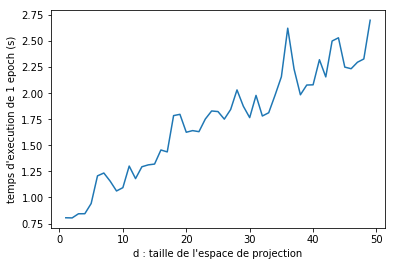

In [32]:
params = {
    "N" : 2,
    "n_epochs" : 1,
    "alpha" : 10**(-3),
    "negative" : 4,
    "d" : 1,
    'n_parallel' : 1000}

TIMES = []
D = []
    
for i in range(1,50):
       
    params["d"]=i
    
    t0=time.time()
    Min, Mout = train_word2vec_parallel(X=X_hot_miserables, params=params, func=func)
    dt=time.time()-t0
    
    D.append(i)
    TIMES.append(dt)

plt.xlabel("d : taille de l'espace de projection")
plt.ylabel("temps d'execution de 1 epoch (s)")
plt.plot(D,TIMES)   

L'augmentation du temps de calcul semble linéaire avec l'augmentation du paramètre d. On observe des sauts qui peuvent être dûs à des effets de bords ou à des lenteurs temporaires de la machine.

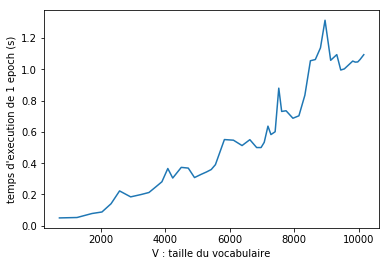

In [33]:
params = {
    "N" : 2,
    "n_epochs" : 1,
    "alpha" : 10**(-3),
    "negative" : 4,
    "d" : 10,
    'n_parallel' : 1000}

V = []
TIMES = []

for i in range (1,50):
    
    doc  = open("data/LesMiserables_cleaned.txt", "r")
    text = doc.read()
    text = text[:i*len(text)//50]
    text = text.split(" ")
    text_serie = pd.Series(text)
    doc.close()

    text_lb_miserables = LabelEncoder()
    X_hot_miserables = text_lb_miserables.fit_transform(text_serie.values)
    
    V.append(np.max(X_hot_miserables))
    
    t0=time.time()
    Min, Mout = train_word2vec_parallel(X=X_hot_miserables, params=params, func=func)
    dt=time.time()-t0
    
    TIMES.append(dt)
    
V = np.array(V)
TIMES = np.array(TIMES)

plt.xlabel("V : taille du vocabulaire")
plt.ylabel("temps d'execution de 1 epoch (s)")
plt.plot(V,TIMES)  

L'augmentation du temps de calcul semble quadratique (mais quasi linéaires étant donnée l'échelle) avec l'augmentation du paramètre V.

## Conclusion

<p style="text-align:justify">
Ce projet a été pour nous, une première approche de la programmation GPU et de l'utilisation de CUDA. Il est très intéressant de pouvoir comprendre les mécanismes de parallélisation des calculs en programmant au moins une fois par nous même avec CUDA.
</p>

<p style="text-align:justify">
Ce projet a été source de nombreuses difficultées pour nous. En premier lieu nous n'avions jamais codé en C et il a fallu rapidemment en comprendre les fondamentaux. Ensuite dans une première approche, l'utilisation de pycuda est relativement difficile (le débogage des fonctions sous CUDA en particulier a été très pénible). L'installation de pycuda nous a également fait perdre beaucoup de temps. De plus les améliorations de l'algorithme proposées dans l'article ne sont pas codées dans l'article, seul l'idée est donnée et il a fallu construire l'algorithme par nous même. Nous sommes tout de même heureux d'avoir réussi à implémenter les techniques de l'article et d'avoir pu observer les gains de performances effectifs qu'ils entraînent. 
</p>

<p style="text-align:justify">
Il aurait été intéressant de pouvoir aller plus loin. Et les pistes suivantes pourraient permettre d'améliorer notre programme et de se rapprocher du code effectivement utilisé par Ji, Shihao, et al. Par exemple il convient d'adapter la parallélisation des calculs à la structure propre de son GPU et nous sommes restés dans un cadre général pour notre implémentation. Aussi il faudrait utiliser les librairies d'algébre linéaire (BLAS) pour constater des performances largement supérieures à celles obtenues. Les fonctions codées en C pourraient également facilement être améliorées mais le fait est que nous débutions dans la pratique du langage. Enfin, pour que les performances de prédiction du réseau de neurones soient améliorées, il faudrait d'avantage travailler en amont sur les données notamment la suppression des mots prépondérants est une astuce cruciale.
</p>

<p style="text-align:justify">
Le résultat principal de notre travail est donc le gain de performance d'un facteur de 80 obtenu en parallélisant l'algorithme word2vec. Via notre implémentation on arrive à entraîner environ 100.000 mots par secondes contre 1.200 sans la parallélisation. Cette méthode est en pratique à la pointe et permet à des clusters puissants d'entraîner jusqu'à plusieurs centaines de millions de mots par seconde sans que l'on observe de perte de convergence et c'est une des clés du travail d'entraînement de bases de données massives.
</p>